In [21]:
import os
import sys
import cmocean
import numpy as np
from netCDF4 import Dataset
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pydap

# import maptools
sys.path.insert(0, os.path.expanduser('~/Dropbox/3. Post-Doc/PF-py'))
from maptools import gridplot, bathymetry, axis
from colorbar_shift import shiftedColorMap 

# Latest forecast models http://nomads.ncep.noaa.gov

# GFS http://nomads.ncep.noaa.gov:9090/dods/gfs_0p25

# CMC http://nomads.ncep.noaa.gov:9090/dods/cmcens/
# (in the ensembles there are the Control model (member 0, c00) and the 20 Perturbed models or members (pXX)

The use of pydap makes retrieving the data from the site really easy in python

In [28]:

from pydap.client import open_url

url = 'http://nomads.ncep.noaa.gov:9090/dods/gfs_0p25/gfs20180523/gfs_0p25_06z'
# create a dataset object
dataset = pydap.client.open_url(url)
 
# print the first 10 values
lat = dataset['lat']
lon = dataset['lon']
tmpsfc = dataset['tmpsfc']
print(dataset)

<DatasetType with children 'absvprs', 'no4lftxsfc', 'no5wavh500mb', 'acpcpsfc', 'albdosfc', 'apcpsfc', 'capesfc', 'cape180_0mb', 'cape255_0mb', 'cfrzrsfc', 'cicepsfc', 'cinsfc', 'cin180_0mb', 'cin255_0mb', 'clwmrprs', 'cpofpsfc', 'cpratsfc', 'crainsfc', 'csnowsfc', 'cwatclm', 'cworkclm', 'dlwrfsfc', 'dpt2m', 'dswrfsfc', 'fldcpsfc', 'gfluxsfc', 'gustsfc', 'hgtsfc', 'hgtprs', 'hgt2pv', 'hgtneg2pv', 'hgttop0c', 'hgt0c', 'hgtmwl', 'hgttrop', 'hindexsfc', 'hlcy3000_0m', 'hpblsfc', 'icahtmwl', 'icahttrop', 'icecsfc', 'icsevprs', 'landsfc', 'landnsfc', 'lftxsfc', 'lhtflsfc', 'msletmsl', 'o3mrprs', 'pevprsfc', 'plpl255_0mb', 'potsig995', 'pratesfc', 'preslclb', 'preslclt', 'presmclb', 'presmclt', 'preshclb', 'preshclt', 'pressfc', 'pres80m', 'pres2pv', 'presneg2pv', 'prescclb', 'prescclt', 'presmwl', 'prestrop', 'prmslmsl', 'pwatclm', 'rhprs', 'rh2m', 'rhsg330_1000', 'rhsg440_1000', 'rhsg720_940', 'rhsg440_720', 'rhsig995', 'rh30_0mb', 'rhclm', 'rhtop0c', 'rh0c', 'shtflsfc', 'snodsfc', 'soilw0

In [48]:
print(tmpsfc['tmpsfc'])
print(len(lat))
print(len(lon))

<BaseType with data BaseProxy('http://nomads.ncep.noaa.gov:9090/dods/gfs_0p25/gfs20180523/gfs_0p25_06z', 'tmpsfc.tmpsfc', dtype('>f4'), (81, 721, 1440), (slice(None, None, None), slice(None, None, None), slice(None, None, None)))>
721
1440


In [14]:
# boundaries of the domain for plotting
p_lon = [-88, -52]
p_lat = [36, 64]
#p_lon = [-180, 180]
#p_lat = [-90, 90]

# bathymetry data for the domain
elon, elat, ez = bathymetry.bathymetry_etopo(p_lon, p_lat)
eland = ez
eland[eland > 0] = 150.

# decrease resolution of topography map
skip = 1
elon = elon[::skip]
elat = elat[::skip]
ez = ez[::skip,::skip]
eland = eland[::skip,::skip]

In [8]:
#url = 'https://nomads.ncdc.noaa.gov/thredds/dodsC/gfs-004/201712/20171227/gfs_4_20171227_1800_384.grb2'
url = 'https://nomads.ncdc.noaa.gov/thredds/dodsC/gfs-004-anl/201712/20171228/gfsanl_4_20171228_0000_006.grb2'
nc = Dataset(url)
lon = nc['lon'][:] - 180
lat = nc['lat'][:]

# index of region of interest
i0 = np.argmin((p_lon[0] - lon) ** 2)
i1 = np.argmin((p_lon[1] - lon) ** 2)+1
j0 = np.argmin((p_lat[1] - lat) ** 2) # gfs is from positive to negative
j1 = np.argmin((p_lat[0] - lat) ** 2)+1
lon = lon[i0:i1]
lat = lat[j0:j1]

# retrieve data
temp = nc['Temperature'][0, :, j0:j1, i0:i1] - 273.25 # to °C
temp_s = nc['Temperature_surface'][0, j0:j1, i0:i1] - 273.25 # to °C

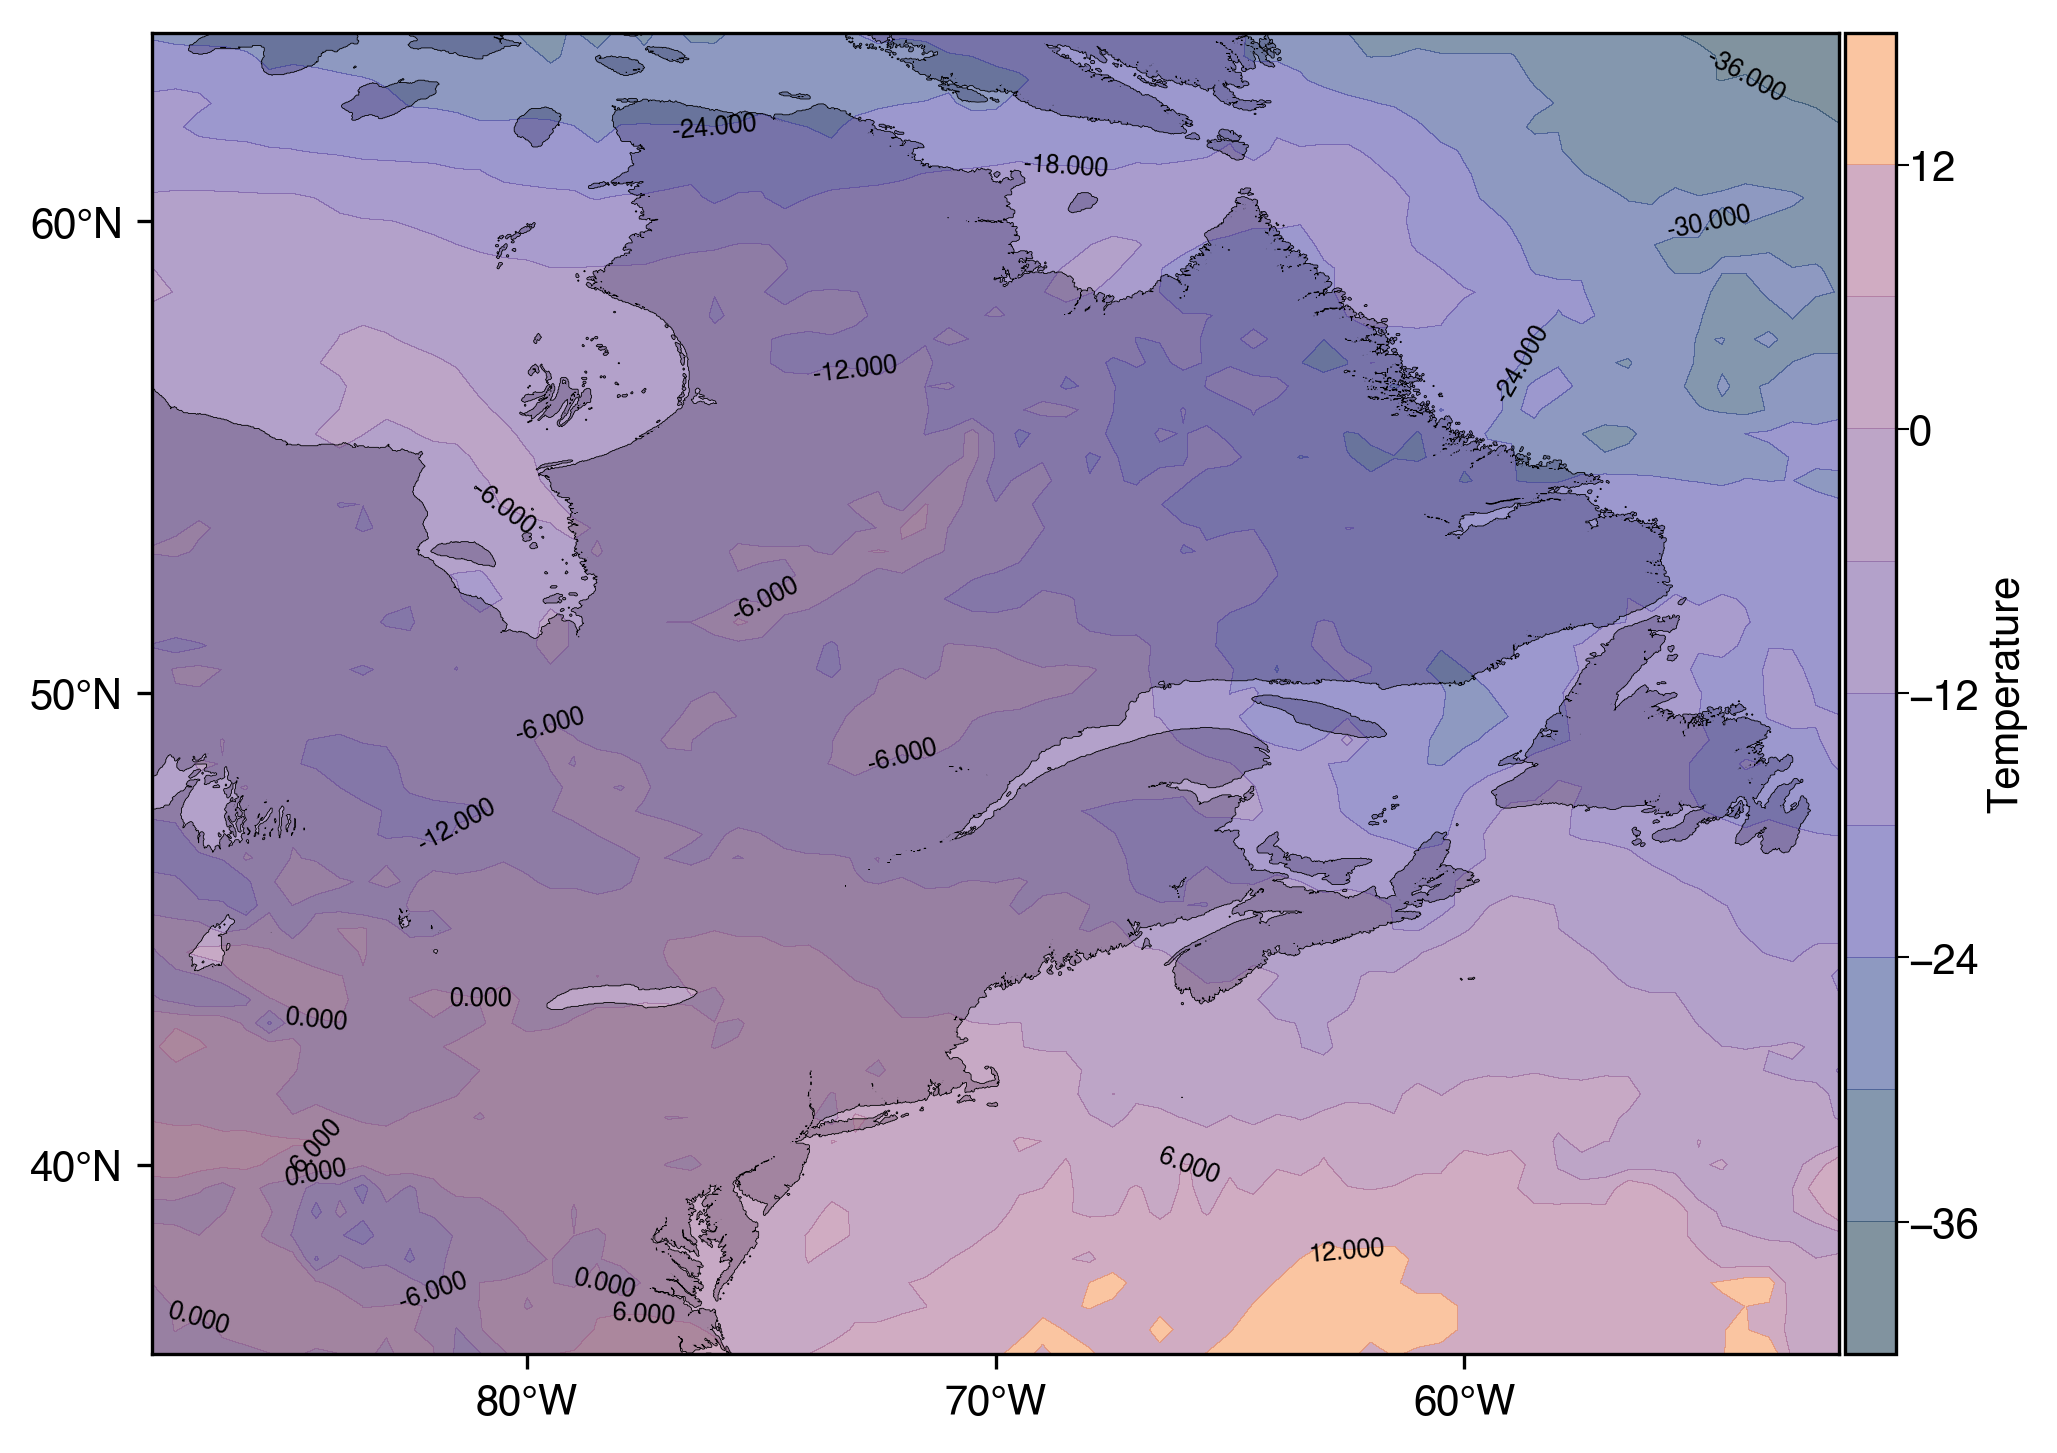

In [9]:
width = 7.5
ratio = (p_lat[1] - p_lat[0]) / (p_lon[1] - p_lon[0])

fig = plt.figure(figsize=(width, width * ratio), dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.contour(elon, elat, ez, [0], colors='black', linewidths=0.2)
ax.contourf(elon, elat, eland, np.arange(0, 510, 10), cmap=cm.binary)
axis.format(ax, 10, 10)

# shift the colorbar according to min/max values
#midpoint = 1 - 5/(np.max(temp[layer]) - np.min(temp[layer]))
midpoint = 1 - 5/(np.max(temp_s) - np.min(temp_s))
thermal = shiftedColorMap(cmocean.cm.thermal, 0, midpoint, 1.0, 'shiftedthermal')
p = ax.contourf(lon, lat, temp_s, 10, cmap=thermal, zorder=1, alpha=0.5)
cs = ax.contour(lon, lat, temp_s, 10, colors='black', linewidths=0)
ax.clabel(cs, fontsize=6)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.02)
cb = fig.colorbar(p, cax=cax)
cb.ax.tick_params(which='major', labelsize=10, length=3, width=0.5, pad=0.05)
cb.set_label('Temperature', size=10, labelpad=2)